In [1]:
import pandas as pd
import numpy as np

In [2]:
## !unzip "/content/drive/MyDrive/ML stuff/dog vision/dog-breed-identification.zip" -d "/content/drive/MyDrive/ML stuff/dog vision/dog-breed-identification"

## End to end image classifier for dog identification using tensorflow 2.0

1. identify a dog breed using its image
2. Data is from kaggle dog breed competetion]
3. For each image in the test set, you must predict a probability for each of the different breeds. The file should contain a header and have the following format:
id,affenpinscher,afghan_hound,..,yorkshire_terrier
000621fb3cbb32d8935728e48679680e,0.0083,0.0,...,0.0083
etc.

link: https://www.kaggle.com/c/dog-breed-identification/overview/evaluation for evaluation info.

In [3]:
import tensorflow as tf
import tensorflow_hub as hub
print(tf.__version__)
print(hub.__version__)

2.5.0
0.12.0


In [4]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Lets load some data and then see how we can convert it into tensors

In [5]:
dog_labels=pd.read_csv("/content/drive/MyDrive/ML stuff/dog vision/dog-breed-identification/labels.csv")

In [6]:
dog_labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


Check images for each label

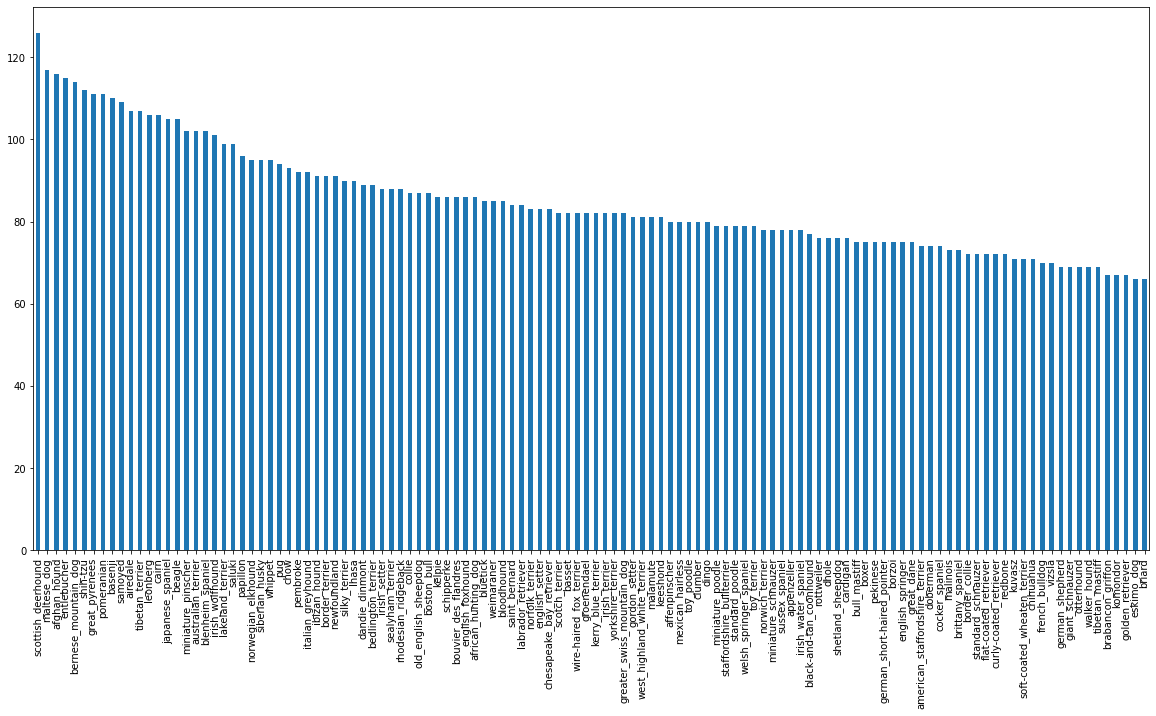

In [7]:
dog_labels["breed"].value_counts().plot.bar(figsize=(20, 10));

In [8]:
dog_labels["breed"].value_counts().mean()

85.18333333333334

Load the images in google colab

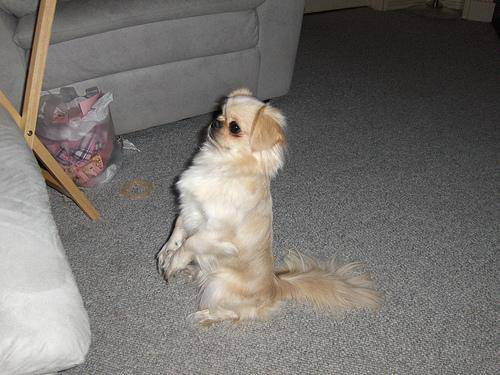

In [9]:
from IPython.display import Image
Image("/content/drive/MyDrive/ML stuff/dog vision/dog-breed-identification/train/001cdf01b096e06d78e9e5112d419397.jpg")


### **TO DO**:
1. get the filenames from the dataframe by adding jpegs and full path to the file ID.
2. check if the filenames matches the number of actual images. If filenames is equal to the actual files move ahead and if not then check the target directory.
3. Check the image at a given index matches the actual image. DO a check on the label ID by checking the breed.


In [46]:
filenames = [ ('/content/drive/MyDrive/ML stuff/dog vision/dog-breed-identification/train/' + names + '.jpg')  for names in dog_labels['id']]
filenames[:10]
len(filenames), dog_labels['id'].count()

(10222, 10222)

In [39]:
labels=np.array(dog_labels['breed'])
labels, len(labels)

(array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
        'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object),
 10222)

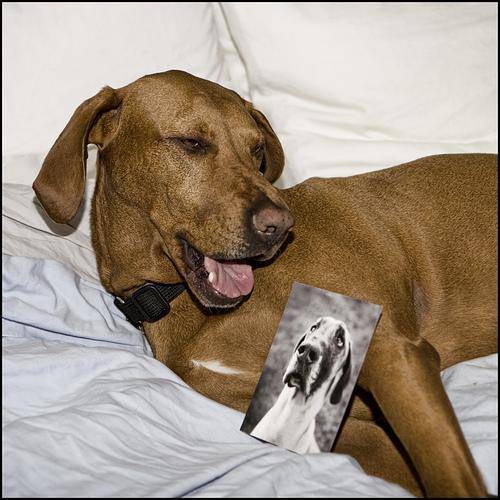

In [50]:
Image(filenames[100])

id       025d903b457b865fd29424916e42fbc2
breed                 rhodesian_ridgeback
Name: 100, dtype: object

In [66]:
unique_breeds=np.unique(labels)
unique_breeds, len(unique_breeds)


(array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
        'american_staffordshire_terrier', 'appenzeller',
        'australian_terrier', 'basenji', 'basset', 'beagle',
        'bedlington_terrier', 'bernese_mountain_dog',
        'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
        'bluetick', 'border_collie', 'border_terrier', 'borzoi',
        'boston_bull', 'bouvier_des_flandres', 'boxer',
        'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
        'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
        'chow', 'clumber', 'cocker_spaniel', 'collie',
        'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
        'doberman', 'english_foxhound', 'english_setter',
        'english_springer', 'entlebucher', 'eskimo_dog',
        'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
        'german_short-haired_pointer', 'giant_schnauzer',
        'golden_retriever', 'gordon_setter', 'gre

In [87]:
bool_labels=[labels==unique_breeds for labels in labels]
len(bool_labels)

10222

In [81]:
np.where(unique_breeds==labels[2]), labels[2]

((array([85]),), 'pekinese')

## So now we have boolean labels(for unique dog breeds and filenames for the filenames of the images of the dogs)

In [89]:
X = filenames
y = bool_labels
len(X), len(y)

(10222, 10222)

In [85]:
## Setup a slider to increase or decrease the image to use for training etc.
images = 2000 #@param {type:"slider", min:1000, max:10222, step:1000}

In [91]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X[:images], y[:images] , test_size=0.2, random_state=42)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [92]:
X_train[:2], y_train[:2]

(['/content/drive/MyDrive/ML stuff/dog vision/dog-breed-identification/train/00bee065dcec471f26394855c5c2f3de.jpg',
  '/content/drive/MyDrive/ML stuff/dog vision/dog-breed-identification/train/0d2f9e12a2611d911d91a339074c8154.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, Fal

## Pre-processing images, Now lets go ahead and convert the images into tensors/numbers. 

1. use the filepath to get the image and then
2. Read the file and save it to a variable
3. Convert image into tensor
4. Resize the image into a smaller size(224, 224) due to the pixel and size variations.
5. Return the modiofied image

In [102]:
## convert to numpy array

from matplotlib.pyplot import imread
image = imread(filenames[50])
image.shape

(240, 320, 3)

In [103]:
image

array([[[176, 163, 146],
        [157, 144, 127],
        [148, 135, 118],
        ...,
        [109,  94,  99],
        [ 76,  60,  70],
        [ 76,  58,  70]],

       [[168, 155, 138],
        [148, 135, 118],
        [150, 137, 120],
        ...,
        [100,  85,  88],
        [ 64,  49,  56],
        [ 87,  70,  80]],

       [[149, 133, 117],
        [126, 113,  96],
        [144, 131, 114],
        ...,
        [108,  94,  93],
        [ 72,  57,  60],
        [ 67,  50,  56]],

       ...,

       [[ 92,  75,  65],
        [ 87,  70,  60],
        [ 76,  62,  51],
        ...,
        [253, 241, 217],
        [254, 242, 220],
        [255, 244, 222]],

       [[ 89,  72,  62],
        [ 86,  69,  59],
        [ 77,  63,  52],
        ...,
        [253, 240, 223],
        [251, 238, 221],
        [249, 236, 220]],

       [[ 85,  68,  58],
        [ 87,  70,  60],
        [ 83,  69,  58],
        ...,
        [255, 244, 228],
        [253, 239, 226],
        [249, 235, 222]]

In [107]:
tf.constant(image)[:2] , image[:2]

(<tf.Tensor: shape=(2, 320, 3), dtype=uint8, numpy=
 array([[[176, 163, 146],
         [157, 144, 127],
         [148, 135, 118],
         ...,
         [109,  94,  99],
         [ 76,  60,  70],
         [ 76,  58,  70]],
 
        [[168, 155, 138],
         [148, 135, 118],
         [150, 137, 120],
         ...,
         [100,  85,  88],
         [ 64,  49,  56],
         [ 87,  70,  80]]], dtype=uint8)>, array([[[176, 163, 146],
         [157, 144, 127],
         [148, 135, 118],
         ...,
         [109,  94,  99],
         [ 76,  60,  70],
         [ 76,  58,  70]],
 
        [[168, 155, 138],
         [148, 135, 118],
         [150, 137, 120],
         ...,
         [100,  85,  88],
         [ 64,  49,  56],
         [ 87,  70,  80]]], dtype=uint8))

In [119]:
## create a function to convert all images into tensors
img_size=224

#function here
def process_image(image_path, size=img_size):
  for path in image_path:
    image = tf.io.read_file(image_path)   #read the file using filepath
    image = tf.image.decode_jpeg(image, channels=3) #convert this into numbers(tensor with 3 co0lor channels)
    ## normalization of the images
    image = tf.image.convert_image_dtype(image, tf.float32) ## IMP this converts the image color channels to values between 0 and 1 rather than 0 and 255
    ## resize the image to 224 8 224
    image = tf.image.resize(image, size=[size, size])  # converts into XxY size image)
    return image

In [111]:
image = tf.io.read_file(filenames[2])
image = tf.image.decode_jpeg(image, channels=3) #convert this into numbers(tensor with 3 co0lor channels)
print(image)
    ## normalization of the images
image1=tf.image.convert_image_dtype(image, tf.float32) ## IMP this converts the image to values between 0 and 1 rather than 0 and 255
print(image1)

tf.Tensor(
[[[ 97  97  89]
  [101 101  93]
  [108 108 100]
  ...
  [  9  11  10]
  [  9  11  10]
  [  9  11  10]]

 [[ 99  99  91]
  [102 102  94]
  [107 107  99]
  ...
  [ 17  19  18]
  [ 17  19  18]
  [ 17  19  18]]

 [[ 98  97  92]
  [ 99  98  93]
  [102 101  96]
  ...
  [  6   8   7]
  [  6   8   7]
  [  6   8   7]]

 ...

 [[192 191 186]
  [193 192 187]
  [195 194 189]
  ...
  [118 117 113]
  [129 128 124]
  [127 126 122]]

 [[198 197 192]
  [199 198 193]
  [200 199 194]
  ...
  [115 115 107]
  [107 106 101]
  [108 108 100]]

 [[199 198 193]
  [200 199 194]
  [202 201 196]
  ...
  [ 95  95  85]
  [ 92  92  84]
  [107 107  97]]], shape=(375, 500, 3), dtype=uint8)
tf.Tensor(
[[[0.3803922  0.3803922  0.34901962]
  [0.39607847 0.39607847 0.3647059 ]
  [0.42352945 0.42352945 0.3921569 ]
  ...
  [0.03529412 0.04313726 0.03921569]
  [0.03529412 0.04313726 0.03921569]
  [0.03529412 0.04313726 0.03921569]]

 [[0.38823533 0.38823533 0.35686275]
  [0.40000004 0.40000004 0.36862746]
  [0.4196

In [124]:
## process images into batches rather than processing 10,000 images(batch size 32)
def get_image_label(image_path, label):
  return process_image(image_path), tf.constant(label)

In [125]:
get_image_label(X[23], y[23])

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.85505086, 0.9299633 , 0.92662823],
         [0.81137955, 0.8680409 , 0.87331927],
         [0.65585613, 0.7117472 , 0.72351193],
         ...,
         [0.9862923 , 1.        , 0.94612277],
         [0.98783255, 1.        , 0.96510875],
         [0.9843138 , 1.        , 0.9686275 ]],
 
        [[0.90201336, 0.96589917, 0.96203256],
         [0.6755214 , 0.7345071 , 0.734637  ],
         [0.3105466 , 0.35756877, 0.36488315],
         ...,
         [0.97476614, 0.98050165, 0.94970876],
         [0.9842786 , 0.9984056 , 0.97540545],
         [0.98680484, 0.99697757, 0.9817803 ]],
 
        [[0.9601525 , 0.99129385, 0.982579  ],
         [0.68598783, 0.7250213 , 0.71138334],
         [0.2921741 , 0.32173467, 0.32030183],
         ...,
         [0.9958709 , 0.99332947, 0.99219996],
         [0.9956618 , 0.99824065, 0.9963235 ],
         [0.99748373, 0.9966649 , 0.9973658 ]],
 
        ...,
 
        [[0.9354203 , 0.91764134

In [126]:
### TO DO lecture 20 and 21

In [127]:
!git remote add origin git@github.com:rajverma1985/dogbreedidentification.git

fatal: not a git repository (or any of the parent directories): .git
